In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import re
from datetime import datetime
from astropy.visualization import astropy_mpl_style, quantity_support
import astropy.units as u
from astropy.coordinates import AltAz, EarthLocation, SkyCoord, ICRS, Longitude
from astropy.time import Time
from helpers.ArrayCoordinate import MidPositions, LowPositions
from helpers.TimeRange import TimeRange

plt.style.use(astropy_mpl_style)

In [2]:
"""Turn into a single Command

Observable(array,target_dict,start_time,obs_period)

Basic function of single command
- Do a Rise/Set plot
- Give Rise/Set times for sources

Extensions... (or from the helpers alone)
- read an SB JSON and make the plot.

"""

'Turn into a single Command\n\nplotObservable(array,target_dict,start_time,obs_period)\n'

## Load array positions

In [6]:
desired_array = 'Mid' #(or 'Low')
if desired_array == 'Mid':
    print("Array:"+desired_array+"\nUsing only SKA dishes ")
    dishes = MidPositions('AncillData/mid_array_coords.dat','SKA')
    average_position = dishes.array_ave_position()
    geographic_location = EarthLocation.from_geocentric(average_position['ave_x'],
                                                        average_position['ave_y'],
                                                        average_position['ave_z'],unit=u.m)
    utcoffset = +2*u.hour
    time_now = Time(datetime.utcnow(), scale='utc') - utcoffset
    time_zone = '[SAST]'
    
elif desired_array == 'Low':
    print("Array:"+desired_array)
    station = LowPositions('AncillData/low_array_coords.dat')
    average_position = station.array_ave_position()
    geographic_location = EarthLocation.from_geocentric(average_position['ave_x'],
                                                        average_position['ave_y'],
                                                        average_position['ave_z'],unit=u.m)
    utcoffset = +8*u.hour
    time_now = Time(datetime.utcnow(), scale='utc') - utcoffset
    time_zone = '[AWST]'
else:
    print("That is not an SKA Telescope ")
    

Array:Mid
Using only SKA dishes 


## Define Time range

In [7]:
obs_time = TimeRange(obs_period_start = '2023-7-5 10:00:01', 
                              obs_period_length = 24.0, 
                              obs_period_unit = 'h', 
                              utcoffset= -2.0,
                              plotsteps = 200)

obs_time_delta = obs_time.obs_period_delta()

## Set Target Coordinate(s) 
Give target coordinate(s) in ICRS

In [65]:
target_dict = {'1646-50': "21:08:46.86357 -50:44:48.37", 
               '1934-638': "19:39:25.026 -63:42:45.63", 
               '1921-293': "19:24:51.055957 -29:14:30.121150",
               'sdc335': "16:30:58.638 -48:43:51.70"}

## Do the plot

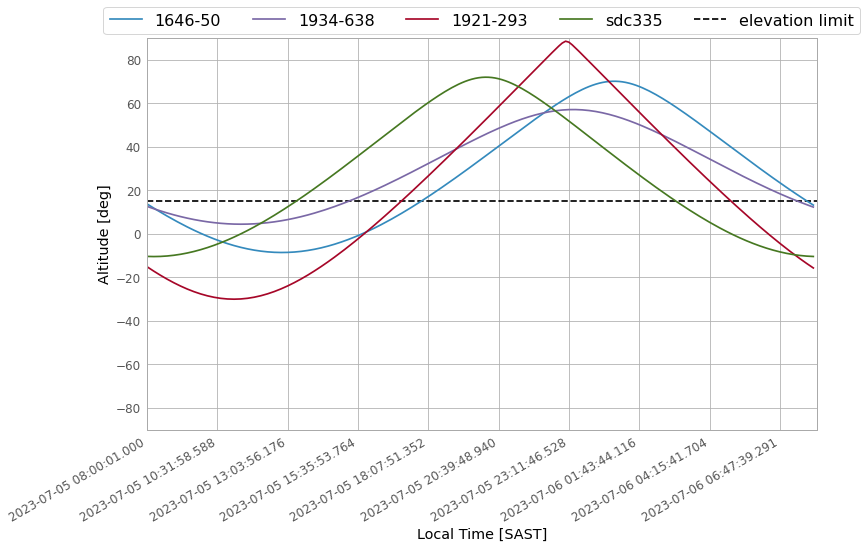

In [72]:
fig_rs = plt.figure(1, figsize=(12,8))
ax_rs = fig_rs.add_subplot(111)

#-- set up the 
ax_rs.set_xlabel('Local Time '+time_zone)
ax_rs.set_ylabel('Altitude [deg]')
ax_rs.hlines(y = 15.0, xmin = 0, xmax = len(obs_time_delta), linestyle = '--', color = 'k', label='elevation limit')
ax_rs.set_xlim([0.0,len(obs_time_delta)])
ax_rs.set_ylim([-90.0,90.0])

for target_name, target_coord in target_dict.items():
    """Conver coords to astropy Skycoord instance"""
    target_coord_sky = SkyCoord(target_coord, frame = 'icrs', unit = (u.hourangle, u.deg))
    """Convert target coords to Az_el (called AltAz in astropy)"""
    target_azel = target_coord_sky.transform_to(AltAz(obstime = obs_time_delta,
                                             location = geographic_location))
    """Plot"""
    ax_rs.plot(obs_time_delta.value,
               target_azel.alt,
               label = target_name)

tick_spacing = 20
ax_rs.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing+1))
ax_rs.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol = len(target_dict)+1
             , fontsize = 16.0)
plt.gcf().autofmt_xdate()
plt.show()


In [73]:
#--- Testing AzAlt for RiseSet statment
# print(target_azel.alt.value)
# print(np.where(np.asarray(target_azel.alt.value))>15.0)
ellim = 15.0
index_above_ellim = np.where(np.asarray(target_azel.alt.value) >= ellim)[0]

if len(index_above_ellim) == len(np.asarray(target_azel.alt.value)):
    print("Source never goes below elevation limit for specified time")
elif len(index_above_ellim) == 0:
     print("Source never goes above elevation limit for specified time")
else:                                 
    for idx in index_above_ellim:
        if target_azel.alt.value[idx - 1] < ellim:
            print("rising between: "+str(obs_time_delta.value[idx - 1])+" and "+obs_time_delta.value[idx])
        elif target_azel.alt.value[idx + 1] < ellim:
            print("setting between: "+str(obs_time_delta.value[idx])+" and "+obs_time_delta.value[idx + 1])
            
""" There is an case here where the last elif will fail if idx is the last index in that array (idx = len(array))
because it can't access idx + 1. But I am  """


rising between: 2023-07-05 13:18:24.518 and 2023-07-05 13:25:38.688
setting between: 2023-07-06 02:56:05.824 and 2023-07-06 03:03:19.995
